In [1]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
!sudo unzip /content/drive/MyDrive/gray_mal_dataset.zip

# Pytorch Transfer Learning Implementation

## DenseNet Model

In [17]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

if torch.cuda.is_available():
    print('CUDA is available. Working on GPU')
    DEVICE = torch.device('cuda')
else:
    print('CUDA is not available. Working on CPU')
    DEVICE = torch.device('cpu')

CUDA is available. Working on GPU


In [60]:
DIR_TRAIN = '/content/drive/MyDrive/gray_mal_dataset/train/'
DIR_TEST = '/content/drive/MyDrive/gray_mal_dataset/val/'

labels = os.listdir(DIR_TRAIN)
labels_val = os.listdir(DIR_TEST)
# Initialize labels encoder
encoder_labels = LabelEncoder()
encoder_labels.fit(labels)

# Create lists of files and labels for training (100'000 items)
files_train = []
labels_train = []
for label in labels:
    # print(label)
    for filename in os.listdir(DIR_TRAIN+label):
        # print(DIR_TRAIN+label+'/'+filename)
        files_train.append(DIR_TRAIN+label+'/'+filename)
        labels_train.append(label)
# print(files_train)
# Create lists of files and labels for validation (10'000 items)
files_val = []
labels_v = []
for val_label in labels_val:
  for val_filename in os.listdir(DIR_TEST+val_label):
      files_val.append(DIR_TEST + val_label+'/'+val_filename)
      labels_v.append(val_label)
print("The first five files from the list of train images:", files_train[:5])
print("\nThe first five labels from the list of train labels:", labels_train[:5])
print("\nThe first five files from the list of validation images:", files_val[:5])
print("\nThe first five labels from the list of validation labels:", labels_v[:5])

The first five files from the list of train images: ['/content/drive/MyDrive/gray_mal_dataset/train/0/1057.png', '/content/drive/MyDrive/gray_mal_dataset/train/0/1090.png', '/content/drive/MyDrive/gray_mal_dataset/train/0/1141.png', '/content/drive/MyDrive/gray_mal_dataset/train/0/1274.png', '/content/drive/MyDrive/gray_mal_dataset/train/0/1297.png']

The first five labels from the list of train labels: ['0', '0', '0', '0', '0']

The first five files from the list of validation images: ['/content/drive/MyDrive/gray_mal_dataset/val/0/1761.png', '/content/drive/MyDrive/gray_mal_dataset/val/0/2094.png', '/content/drive/MyDrive/gray_mal_dataset/val/0/2130.png', '/content/drive/MyDrive/gray_mal_dataset/val/0/2138.png', '/content/drive/MyDrive/gray_mal_dataset/val/0/2173.png']

The first five labels from the list of validation labels: ['0', '0', '0', '0', '0']


In [61]:
class ImagesDataset(Dataset):
    def __init__(self, files, labels, encoder, transforms, mode):
        super().__init__()
        self.files = files
        self.labels = labels
        self.encoder = encoder
        self.transforms = transforms
        self.mode = mode

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        pic = Image.open(self.files[index]).convert('RGB')

        if self.mode == 'train' or self.mode == 'val':
            x = self.transforms(pic)
            label = self.labels[index]
            y = self.encoder.transform([label])[0]
            return x, y
        
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    transforms.RandomErasing(p=0.5, scale=(0.06, 0.08), ratio=(1, 3), value=0, inplace=True)
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
])

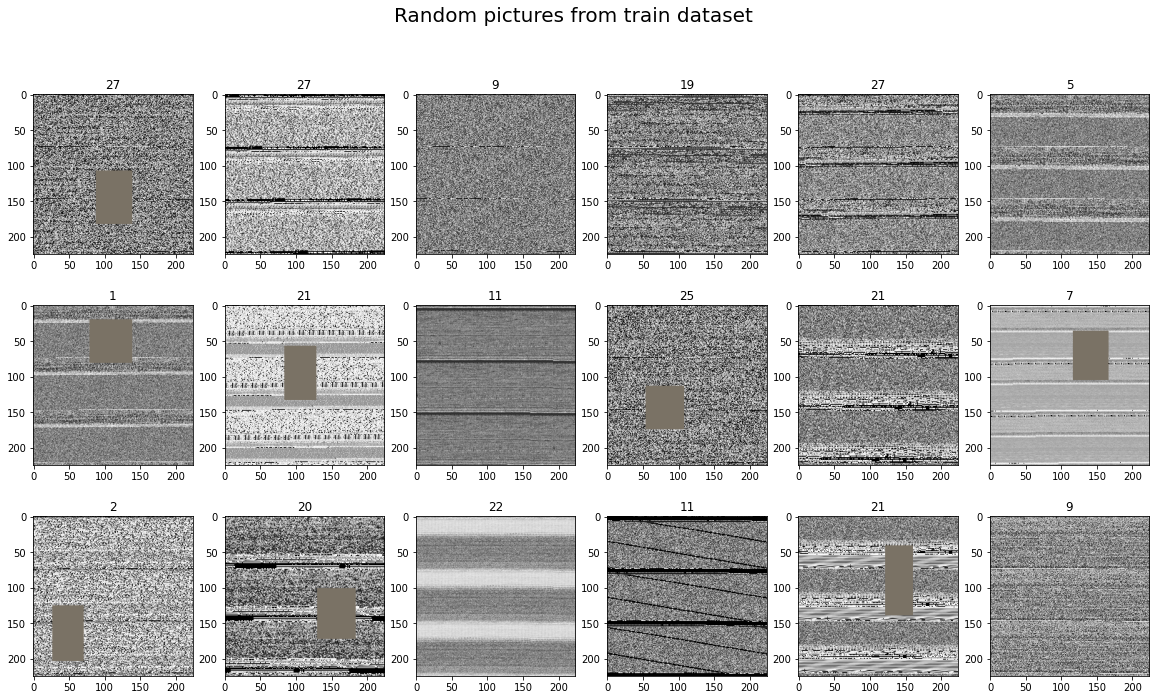

In [67]:
train_dataset = ImagesDataset(files=files_train,
                              labels=labels_train,
                              encoder=encoder_labels,
                              transforms=transforms_train,
                              mode='train')

val_dataset = ImagesDataset(files=files_val,
                            labels=labels_v,
                            encoder=encoder_labels,
                            transforms=transforms_val,
                            mode='val')


fig, axs = plt.subplots(3, 6, figsize=(20,11))
fig.suptitle('Random pictures from train dataset', fontsize=20)
for ax in axs.flatten():
    n = np.random.randint(len(train_dataset))
    img = train_dataset[n][0]
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.4802, 0.4481, 0.3975])
    std = np.array([0.2302, 0.2265, 0.2262])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.set_title(encoder_labels.inverse_transform([train_dataset[n][1]])[0])
    ax.imshow(img)

In [68]:
def training(model, model_name, num_epochs, train_dataloader, val_dataloader):

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.33)

    train_loss_array = []
    train_acc_array = []
    val_loss_array = []
    val_acc_array = []
    lowest_val_loss = np.inf
    best_model = None

    for epoch in tqdm(range(num_epochs)):

        print('Epoch: {} | Learning rate: {}'.format(epoch + 1, scheduler.get_lr()))

        for phase in ['train', 'val']:

            epoch_loss = 0
            epoch_correct_items = 0
            epoch_items = 0

            if phase == 'train':
                model.train()
                with torch.enable_grad():
                    for samples, targets in train_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        optimizer.zero_grad()
                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()
                        
                        loss.backward()
                        optimizer.step()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)
                print(epoch_items)

                train_loss_array.append(epoch_loss / epoch_items)
                train_acc_array.append(epoch_correct_items / epoch_items)

                scheduler.step()

            elif phase == 'val':
                model.eval()
                with torch.no_grad():
                    for samples, targets in val_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)
                print(epoch_items)

                val_loss_array.append(epoch_loss / epoch_items)
                val_acc_array.append(epoch_correct_items / epoch_items)

                if epoch_loss / epoch_items < lowest_val_loss:
                    lowest_val_loss = epoch_loss / epoch_items
                    torch.save(model.state_dict(), '{}_weights.pth'.format(model_name))
                    best_model = copy.deepcopy(model)
                    print("\t| New lowest val loss for {}: {}".format(model_name, lowest_val_loss))

    return best_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array

In [69]:
def visualize_training_results(train_loss_array,
                               val_loss_array,
                               train_acc_array,
                               val_acc_array,
                               num_epochs,
                               model_name,
                               batch_size):
    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle("{} training | Batch size: {}".format(model_name, batch_size), fontsize = 16)
    axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
    axs[0].plot(list(range(1, num_epochs+1)), val_loss_array, label="val_loss")
    axs[0].legend(loc='best')
    axs[0].set(xlabel='epochs', ylabel='loss')
    axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
    axs[1].plot(list(range(1, num_epochs+1)), val_acc_array, label="val_acc")
    axs[1].legend(loc='best')
    axs[1].set(xlabel='epochs', ylabel='accuracy')
    plt.show();

In [75]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
num_epochs = 10

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]
2857
726


 10%|█         | 1/10 [00:36<05:25, 36.16s/it]

	| New lowest val loss for DenseNet161: 0.051169431899204726
Epoch: 2 | Learning rate: [0.0003]
2857
726


 20%|██        | 2/10 [01:12<04:49, 36.14s/it]

	| New lowest val loss for DenseNet161: 0.0511519041928378
Epoch: 3 | Learning rate: [0.0003]
2857
726


 30%|███       | 3/10 [01:48<04:12, 36.10s/it]

	| New lowest val loss for DenseNet161: 0.050947274715118826
Epoch: 4 | Learning rate: [3.267e-05]
2857


 40%|████      | 4/10 [02:23<03:34, 35.82s/it]

726
Epoch: 5 | Learning rate: [9.9e-05]
2857


 50%|█████     | 5/10 [02:59<02:58, 35.65s/it]

726
Epoch: 6 | Learning rate: [9.9e-05]
2857


 60%|██████    | 6/10 [03:34<02:21, 35.49s/it]

726
Epoch: 7 | Learning rate: [1.0781099999999999e-05]
2857


 70%|███████   | 7/10 [04:09<01:46, 35.47s/it]

726
Epoch: 8 | Learning rate: [3.267e-05]
2857


 80%|████████  | 8/10 [04:44<01:10, 35.40s/it]

726
Epoch: 9 | Learning rate: [3.267e-05]
2857


 90%|█████████ | 9/10 [05:20<00:35, 35.36s/it]

726
Epoch: 10 | Learning rate: [3.557763e-06]
2857


100%|██████████| 10/10 [05:55<00:00, 35.54s/it]

726


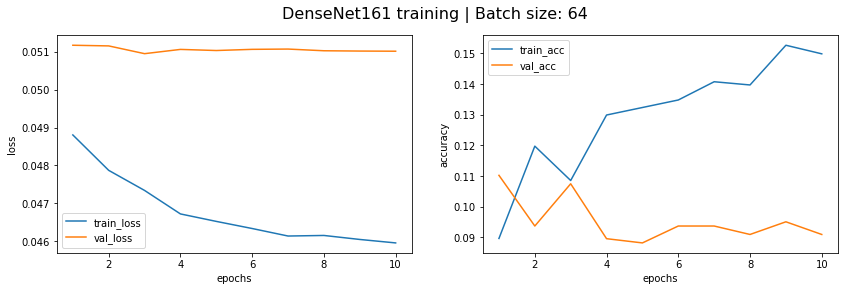


Training results:
	Min val loss 0.0509 was achieved during epoch #3
	Val accuracy during min val loss is 0.1074


In [79]:
model_densenet161 = models.densenet161(pretrained=True)
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, out_features=28)
model_densenet161 = model_densenet161.to(DEVICE)

densenet161_training_results = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=train_dataloader,
                                        val_dataloader=val_dataloader)

model_densenet161, train_loss_array, train_acc_array, val_loss_array, val_acc_array = densenet161_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="DenseNet161",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

## ResNet152

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]
2857
726


 10%|█         | 1/10 [00:36<05:27, 36.39s/it]

	| New lowest val loss for ResNet152: 0.0515073945042844
Epoch: 2 | Learning rate: [0.0003]
2857
726


 20%|██        | 2/10 [01:12<04:51, 36.44s/it]

	| New lowest val loss for ResNet152: 0.050629463734377184
Epoch: 3 | Learning rate: [0.0003]
2857


 30%|███       | 3/10 [01:48<04:11, 35.90s/it]

726
Epoch: 4 | Learning rate: [3.267e-05]
2857


 40%|████      | 4/10 [02:23<03:33, 35.64s/it]

726
Epoch: 5 | Learning rate: [9.9e-05]
2857


 50%|█████     | 5/10 [02:58<02:56, 35.38s/it]

726
Epoch: 6 | Learning rate: [9.9e-05]
2857


 60%|██████    | 6/10 [03:33<02:21, 35.39s/it]

726
Epoch: 7 | Learning rate: [1.0781099999999999e-05]
2857


 70%|███████   | 7/10 [04:08<01:45, 35.27s/it]

726
Epoch: 8 | Learning rate: [3.267e-05]
2857


 80%|████████  | 8/10 [04:43<01:10, 35.24s/it]

726
Epoch: 9 | Learning rate: [3.267e-05]
2857


 90%|█████████ | 9/10 [05:18<00:35, 35.16s/it]

726
Epoch: 10 | Learning rate: [3.557763e-06]
2857


100%|██████████| 10/10 [05:53<00:00, 35.40s/it]

726


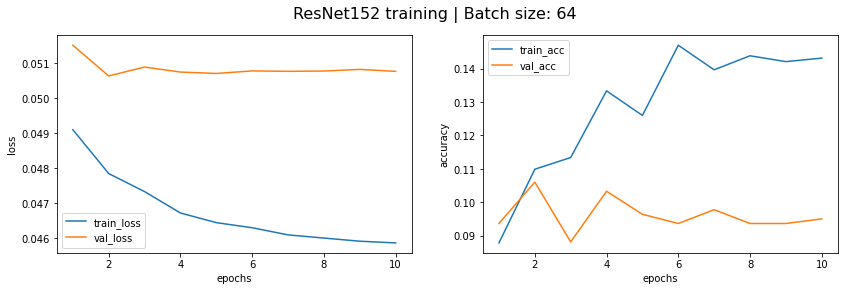


Training results:
	Min val loss 0.0506 was achieved during epoch #2
	Val accuracy during min val loss is 0.1061


In [78]:
model_resnet152 = models.resnet152(pretrained=True)
for param in model_resnet152.parameters():
    param.requires_grad = False
model_resnet152.fc = torch.nn.Linear(model_resnet152.fc.in_features, 28)
model_resnet152 = model_resnet152.to(DEVICE)

resnet152_training_results = training(model=model_resnet152,
                                      model_name='ResNet152',
                                      num_epochs=num_epochs,
                                      train_dataloader=train_dataloader,
                                      val_dataloader=val_dataloader)

model_resnet152, train_loss_array, train_acc_array, val_loss_array, val_acc_array = resnet152_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="ResNet152",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

## VGG19 model

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]
2857
726


 10%|█         | 1/10 [00:35<05:16, 35.12s/it]

	| New lowest val loss for VGG19_bn: 0.050962705914310846
Epoch: 2 | Learning rate: [0.0003]
2857


 20%|██        | 2/10 [01:08<04:32, 34.09s/it]

726
Epoch: 3 | Learning rate: [0.0003]
2857


 30%|███       | 3/10 [01:40<03:52, 33.28s/it]

726
Epoch: 4 | Learning rate: [3.267e-05]
2857


 40%|████      | 4/10 [02:13<03:17, 32.97s/it]

726
Epoch: 5 | Learning rate: [9.9e-05]
2857


 50%|█████     | 5/10 [02:45<02:43, 32.77s/it]

726
Epoch: 6 | Learning rate: [9.9e-05]
2857


 60%|██████    | 6/10 [03:18<02:10, 32.73s/it]

726
Epoch: 7 | Learning rate: [1.0781099999999999e-05]
2857


 70%|███████   | 7/10 [03:50<01:37, 32.63s/it]

726
Epoch: 8 | Learning rate: [3.267e-05]
2857


 80%|████████  | 8/10 [04:23<01:05, 32.57s/it]

726
Epoch: 9 | Learning rate: [3.267e-05]
2857


 90%|█████████ | 9/10 [04:55<00:32, 32.52s/it]

726
Epoch: 10 | Learning rate: [3.557763e-06]
2857


100%|██████████| 10/10 [05:28<00:00, 32.82s/it]

726


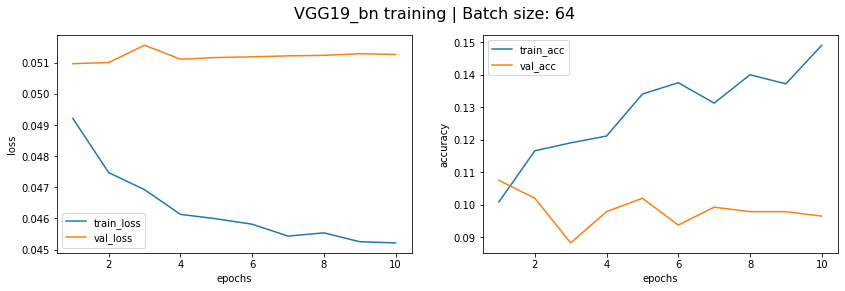


Training results:
	Min val loss 0.0510 was achieved during epoch #1
	Val accuracy during min val loss is 0.1074


In [80]:
model_vgg19_bn = models.vgg19_bn(pretrained=True)
for param in model_vgg19_bn.parameters():
    param.requires_grad = False
model_vgg19_bn.classifier[6] = torch.nn.Linear(in_features=model_vgg19_bn.classifier[6].in_features, out_features=28)
model_vgg19_bn = model_vgg19_bn.to(DEVICE)

vgg19_bn_training_results = training(model=model_vgg19_bn,
                                     model_name='VGG19_bn',
                                     num_epochs=num_epochs,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader)

model_vgg19_bn, train_loss_array, train_acc_array, val_loss_array, val_acc_array = vgg19_bn_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="VGG19_bn",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

In [85]:
class EnsembleModel(nn.Module):   
    def __init__(self, modelA, modelB, modelC):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        self.classifier = nn.Linear(28 * 3, 28)
        
    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x3 = self.modelC(x)
        x = torch.cat((x1, x2, x3), dim=1)
        out = self.classifier(x)
        return out
    
ensemble_model = EnsembleModel(model_densenet161, model_resnet152, model_vgg19_bn)

for param in ensemble_model.parameters():
    param.requires_grad = False

for param in ensemble_model.classifier.parameters():
    param.requires_grad = True    

ensemble_model = ensemble_model.to(DEVICE)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]
2857
726


  5%|▌         | 1/20 [01:28<28:04, 88.67s/it]

	| New lowest val loss for Ensemble: 0.05186156037753607
Epoch: 2 | Learning rate: [0.0003]
2857
726


 10%|█         | 2/20 [02:58<26:43, 89.07s/it]

	| New lowest val loss for Ensemble: 0.05077554831491686
Epoch: 3 | Learning rate: [0.0003]
2857
726


 15%|█▌        | 3/20 [04:27<25:13, 89.04s/it]

	| New lowest val loss for Ensemble: 0.050624585020312265
Epoch: 4 | Learning rate: [3.267e-05]
2857
726


 20%|██        | 4/20 [05:56<23:44, 89.03s/it]

	| New lowest val loss for Ensemble: 0.05061888826123282
Epoch: 5 | Learning rate: [9.9e-05]
2857


 25%|██▌       | 5/20 [07:21<21:53, 87.58s/it]

726
Epoch: 6 | Learning rate: [9.9e-05]
2857


 30%|███       | 6/20 [08:45<20:11, 86.52s/it]

726
Epoch: 7 | Learning rate: [1.0781099999999999e-05]
2857
726


 35%|███▌      | 7/20 [10:14<18:55, 87.32s/it]

	| New lowest val loss for Ensemble: 0.050611663455805506
Epoch: 8 | Learning rate: [3.267e-05]
2857
726


 40%|████      | 8/20 [11:43<17:34, 87.92s/it]

	| New lowest val loss for Ensemble: 0.05061147593926464
Epoch: 9 | Learning rate: [3.267e-05]
2857


 45%|████▌     | 9/20 [13:08<15:57, 87.03s/it]

726
Epoch: 10 | Learning rate: [3.557763e-06]
2857


 50%|█████     | 10/20 [14:33<14:22, 86.26s/it]

726
Epoch: 11 | Learning rate: [1.0781099999999999e-05]
2857


 55%|█████▌    | 11/20 [15:57<12:51, 85.74s/it]

726
Epoch: 12 | Learning rate: [1.0781099999999999e-05]
2857
726


 60%|██████    | 12/20 [17:26<11:32, 86.60s/it]

	| New lowest val loss for Ensemble: 0.050593323615628495
Epoch: 13 | Learning rate: [1.17406179e-06]
2857


 65%|██████▌   | 13/20 [18:51<10:02, 86.08s/it]

726
Epoch: 14 | Learning rate: [3.557763e-06]
2857


 70%|███████   | 14/20 [20:15<08:33, 85.62s/it]

726
Epoch: 15 | Learning rate: [3.557763e-06]
2857


 75%|███████▌  | 15/20 [21:40<07:06, 85.33s/it]

726
Epoch: 16 | Learning rate: [3.874403907e-07]
2857


 80%|████████  | 16/20 [23:06<05:41, 85.41s/it]

726
Epoch: 17 | Learning rate: [1.17406179e-06]
2857


 85%|████████▌ | 17/20 [24:30<04:15, 85.11s/it]

726
Epoch: 18 | Learning rate: [1.17406179e-06]
2857


 90%|█████████ | 18/20 [25:55<02:49, 84.95s/it]

726
Epoch: 19 | Learning rate: [1.27855328931e-07]
2857


 95%|█████████▌| 19/20 [27:19<01:24, 84.72s/it]

726
Epoch: 20 | Learning rate: [3.874403907e-07]
2857


100%|██████████| 20/20 [28:43<00:00, 86.19s/it]

726


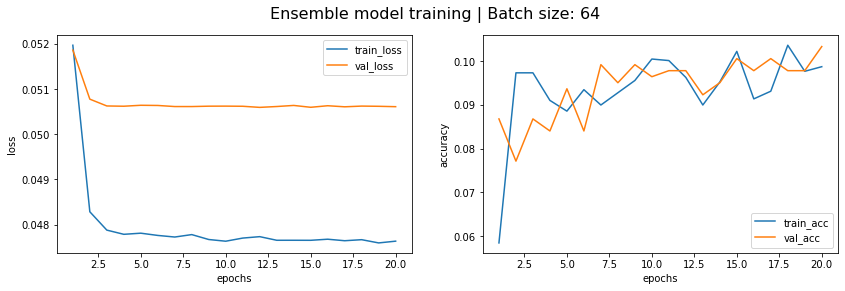


Training results:
	Min val loss 0.0506 was achieved during iteration #12
	Val accuracy during min val loss is 0.0978


In [86]:
ensemble_training_results = training(model=ensemble_model,
                                     model_name='Ensemble',
                                     num_epochs=20,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader)

ensemble_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array = ensemble_training_results

min_loss = min(val_loss_array)
min_loss_iteration = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_iteration]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs=20,
                           model_name="Ensemble model",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during iteration #{}".format(min_loss, min_loss_iteration + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

In [91]:
test_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

all_preds = []
all_files = []

ensemble_model.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader):
        # print(f_names)
        samples = samples.to(DEVICE)
        outputs = ensemble_model(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_files.extend(f_names)
# print(all_files)

all_filenames = [f_name for f_name in all_files]
all_preds_decoded = encoder_labels.inverse_transform(all_preds)

submission_ensemble_df = pd.DataFrame(list(zip(all_filenames, all_preds_decoded)), columns =['File', 'Prediction'])
submission_ensemble_df.to_csv('test_predictions_ensemble.csv', header=False, index=False) 
submission_ensemble_df.head(10)

100%|██████████| 12/12 [00:16<00:00,  1.39s/it]

[tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(6), tensor(6), tensor(6), tensor(6), tensor(6), tensor(6), tensor(6), tensor(7), tensor(7), tensor(7), tensor(7), tensor(7)

,File,Prediction
0,tensor(0),8
1,tensor(0),4
2,tensor(0),20
3,tensor(0),8
4,tensor(0),21
5,tensor(0),4
6,tensor(0),20
7,tensor(0),20
8,tensor(0),21
9,tensor(0),27


In [97]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from sklearn.metrics import plot_confusion_matrix

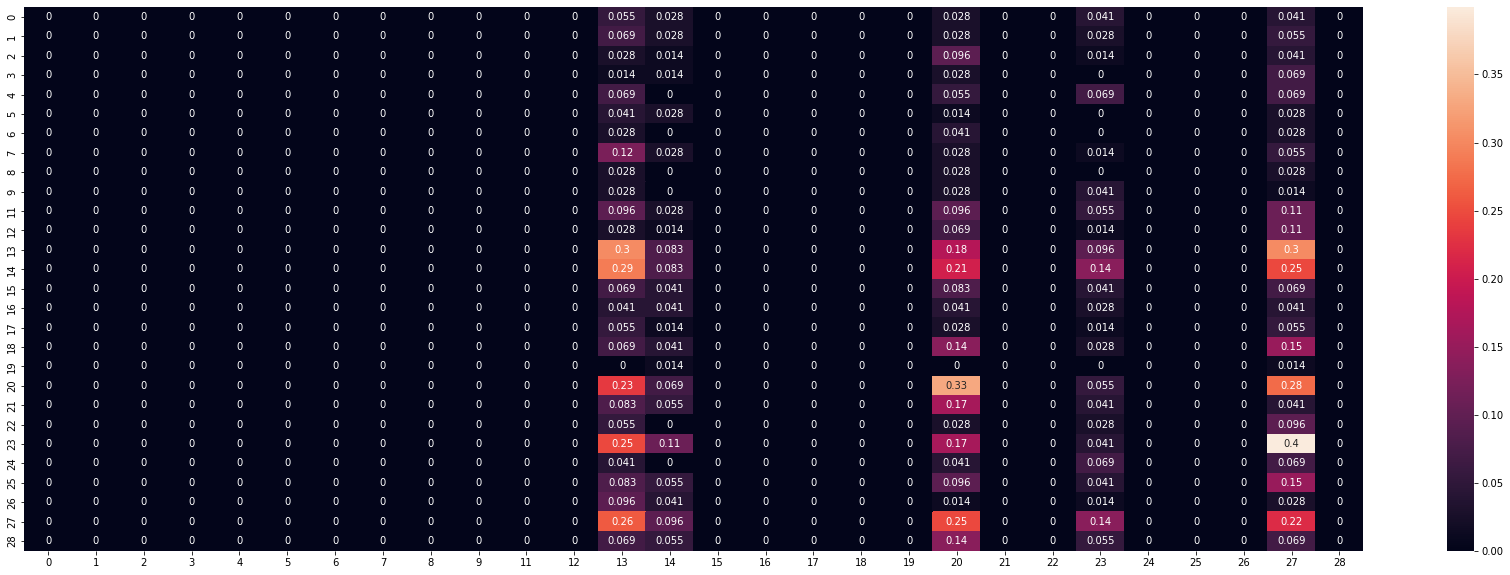

In [108]:
# y_pred = []
# y_true = []

# iterate over test data
# for inputs, labels in testloader:
#         output = net(inputs) # Feed Network

#         output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
#         y_pred.extend(output) # Save Prediction
        
#         labels = labels.data.cpu().numpy()
#         y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0', '1','2', '3', '4', '5', '6', '7', '8', '9', '11', '12', '13', '14',
           '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28')

# Build confusion matrix
cf_matrix = confusion_matrix(labels_v, all_preds_decoded)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (30,10))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')